In [1]:
import numpy as np
import pandas as pd
pd.set_option('display.max_columns', 50)

import seaborn as sns
import matplotlib.pyplot as plt

from imblearn.over_sampling import SMOTE

from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score, classification_report, confusion_matrix
from sklearn.preprocessing import RobustScaler
from sklearn.linear_model import SGDClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import AdaBoostClassifier

In [2]:
data = pd.read_csv('Heart_AfterPrep_0228.csv')
print(len(data))

274034


# Data Category

In [3]:
data.loc[data['GeneralHealth'] == 'Poor', 'GeneralHealth'] = 0
data.loc[data['GeneralHealth'] == 'Fair', 'GeneralHealth'] = 1
data.loc[data['GeneralHealth'] == 'Good', 'GeneralHealth'] = 2
data.loc[data['GeneralHealth'] == 'Very good', 'GeneralHealth'] = 3
data.loc[data['GeneralHealth'] == 'Excellent', 'GeneralHealth'] = 4
data['GeneralHealth'] = data['GeneralHealth'].astype('int32')

data.loc[data['LastCheckupTime'] == '5 or more years ago', 'LastCheckupTime'] = 0
data.loc[data['LastCheckupTime'] == 'Within past 5 years (2 years but less than 5 years ago)', 'LastCheckupTime'] = 1
data.loc[data['LastCheckupTime'] == 'Within past 2 years (1 year but less than 2 years ago)', 'LastCheckupTime'] = 2
data.loc[data['LastCheckupTime'] == 'Within past year (anytime less than 12 months ago)', 'LastCheckupTime'] = 3
data['LastCheckupTime'] = data['LastCheckupTime'].astype('int32')

data.loc[data['SmokerStatus'] == 'Current smoker - now smokes every day', 'SmokerStatus'] = 0
data.loc[data['SmokerStatus'] == 'Current smoker - now smokes some days', 'SmokerStatus'] = 1
data.loc[data['SmokerStatus'] == 'Former smoker', 'SmokerStatus'] = 2
data.loc[data['SmokerStatus'] == 'Never smoked', 'SmokerStatus'] = 3
data['SmokerStatus'] = data['SmokerStatus'].astype('int32')

data.loc[data['ECigaretteUsage'] == 'Use them every day', 'ECigaretteUsage'] = 0
data.loc[data['ECigaretteUsage'] == 'Use them some days', 'ECigaretteUsage'] = 1
data.loc[data['ECigaretteUsage'] == 'Not at all (right now)', 'ECigaretteUsage'] = 2
data.loc[data['ECigaretteUsage'] == 'Never used e-cigarettes in my entire life', 'ECigaretteUsage'] = 3
data['ECigaretteUsage'] = data['ECigaretteUsage'].astype('float')

data.loc[data['RemovedTeeth'] == 'All', 'RemovedTeeth'] = 0
data.loc[data['RemovedTeeth'] == '6 or more, but not all', 'RemovedTeeth'] = 1
data.loc[data['RemovedTeeth'] == '1 to 5', 'RemovedTeeth'] = 2
data.loc[data['RemovedTeeth'] == 'None of them', 'RemovedTeeth'] = 3
data.loc[data['RemovedTeeth'] == 'None of Them', 'RemovedTeeth'] = 3
data['RemovedTeeth'] = data['RemovedTeeth'].astype('float')

In [4]:
ages = {
    'Age 80 or older': 80,
    'Age 55 to 59': 55,
    'Age 40 to 44': 40,
    'Age 75 to 79': 75,
    'Age 70 to 74': 70,
    'Age 65 to 69': 65,
    'Age 60 to 64': 60,
    'Age 50 to 54': 50,
    'Age 45 to 49': 45,
    'Age 35 to 39': 35,
    'Age 25 to 29': 25,
    'Age 30 to 34': 30,
    'Age 18 to 24': 18
}

data['AgeCategory'] = data['AgeCategory'].map(lambda x: ages[x])

In [5]:
data = pd.get_dummies(data, columns = ['RaceEthnicityCategory', 'TetanusLast10Tdap'])
le = LabelEncoder()
for columns in data.select_dtypes(include = ['object', 'bool']).columns:
    data[columns] = le.fit_transform(data[columns])

In [6]:
data.isna().sum()

State                                                                          0
Sex                                                                            0
GeneralHealth                                                                  0
PhysicalHealthDays                                                             0
MentalHealthDays                                                               0
LastCheckupTime                                                                0
PhysicalActivities                                                             0
SleepHours                                                                     0
RemovedTeeth                                                                   0
HadHeartAttack                                                                 0
HadAngina                                                                      0
HadStroke                                                                      0
HadAsthma                   

# Modeling

## 기본 파일로 모델 훈련

In [7]:
X = data.drop('HadHeartAttack', axis = 1)
y = data['HadHeartAttack']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 1234)

<Axes: xlabel='HadHeartAttack', ylabel='count'>

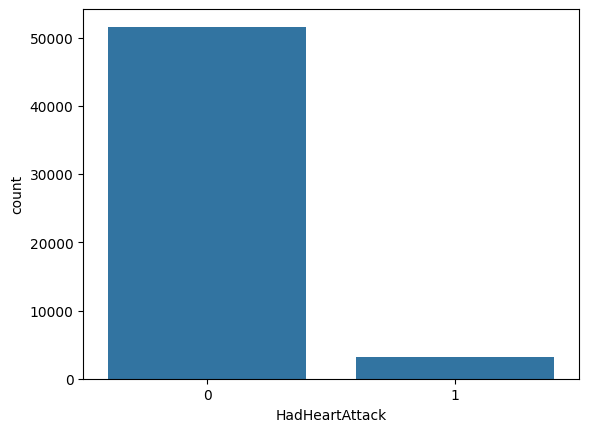

In [9]:
yDF = pd.DataFrame(y_test, columns = ['HadHeartAttack'])
sns.countplot(x = 'HadHeartAttack', data = yDF)

### SGD Classifier

In [11]:
sgd = SGDClassifier(random_state = 1234)
sgd.fit(X_train, y_train)

SGDClassifier(random_state=1234)

In [12]:
sgd_pred = sgd.predict(X_test)
sgd_acc = accuracy_score(y_test, sgd_pred)
print(f'SGD Classifier (Basic) Accuracy: {sgd_acc*100:.2f}%')

SGD Classifier (Basic) Accuracy: 94.26%


In [13]:
print(classification_report(y_test, sgd_pred))

              precision    recall  f1-score   support

           0       0.95      0.99      0.97     51607
           1       0.54      0.12      0.20      3200

    accuracy                           0.94     54807
   macro avg       0.74      0.56      0.58     54807
weighted avg       0.92      0.94      0.93     54807



In [14]:
sgd_f1 = f1_score(y_test, sgd_pred)
print(f'SGD Classifier (Basic) F1 score: {sgd_f1:.4f}')

SGD Classifier (Basic) F1 score: 0.1980


### AdaBoost

In [15]:
clf = AdaBoostClassifier(random_state = 1234)
clf.fit(X_train, y_train)

AdaBoostClassifier(random_state=1234)

In [16]:
clf_pred = clf.predict(X_test)
clf_acc = accuracy_score(y_test, clf_pred)
print(f'AdaBoost (Basic) Accuracy: {clf_acc*100:.2f}%')

AdaBoost (Basic) Accuracy: 94.48%


In [17]:
print(classification_report(y_test, clf_pred))

              precision    recall  f1-score   support

           0       0.96      0.99      0.97     51607
           1       0.56      0.26      0.36      3200

    accuracy                           0.94     54807
   macro avg       0.76      0.63      0.67     54807
weighted avg       0.93      0.94      0.94     54807



In [18]:
clf_f1 = f1_score(y_test, clf_pred)
print(f'AdaBoost (Basic) F1 score {clf_f1:.4f}')

AdaBoost (Basic) F1 score 0.3591


## 이상치를 IQR 처리하고 Robust Scaling

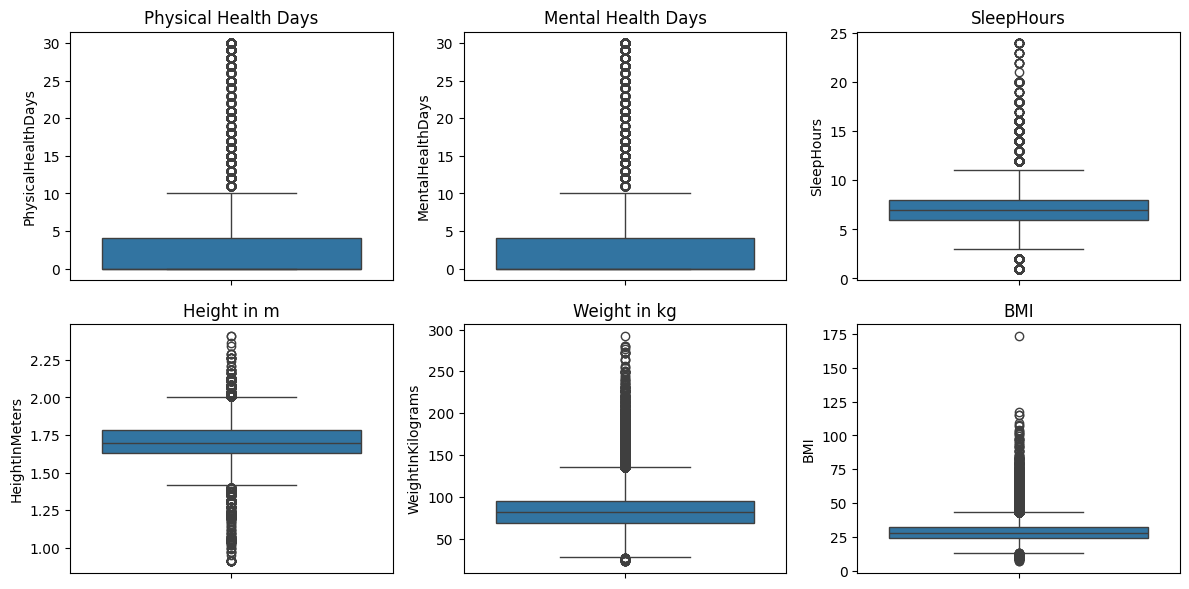

In [138]:
plt.figure(figsize = (12, 6))

plt.subplot(2, 3, 1)
sns.boxplot(data = data['PhysicalHealthDays'])
plt.title('Physical Health Days')

plt.subplot(2, 3, 2)
sns.boxplot(data = data['MentalHealthDays'])
plt.title('Mental Health Days')

plt.subplot(2, 3, 3)
sns.boxplot(data = data['SleepHours'])
plt.title('SleepHours')

plt.subplot(2, 3, 4)
sns.boxplot(data = data['HeightInMeters'])
plt.title('Height in m')

plt.subplot(2, 3, 5)
sns.boxplot(data = data['WeightInKilograms'])
plt.title('Weight in kg')

plt.subplot(2, 3, 6)
sns.boxplot(data = data['BMI'])
plt.title('BMI')

plt.tight_layout()
plt.show()

In [8]:
Q1 = data[['SleepHours', 'BMI']].quantile(q = 0.25)
Q3 = data[['SleepHours', 'BMI']].quantile(q = 0.75)
IQR = Q3-Q1
data_iqr = data[(data['SleepHours'] <= Q3['SleepHours']+IQR['SleepHours']*1.5)&(data['SleepHours'] >= Q1['SleepHours']-IQR['SleepHours']*1.5)]
data_iqr = data_iqr[(data_iqr['BMI'] <= Q3['BMI']+IQR['BMI']*1.5)&(data_iqr['BMI'] >= Q1['BMI']-IQR['BMI']*1.5)]
print('Original data:', len(data))
print('Remove Outlier data:', len(data_iqr))

Original data: 274034
Remove Outlier data: 261812


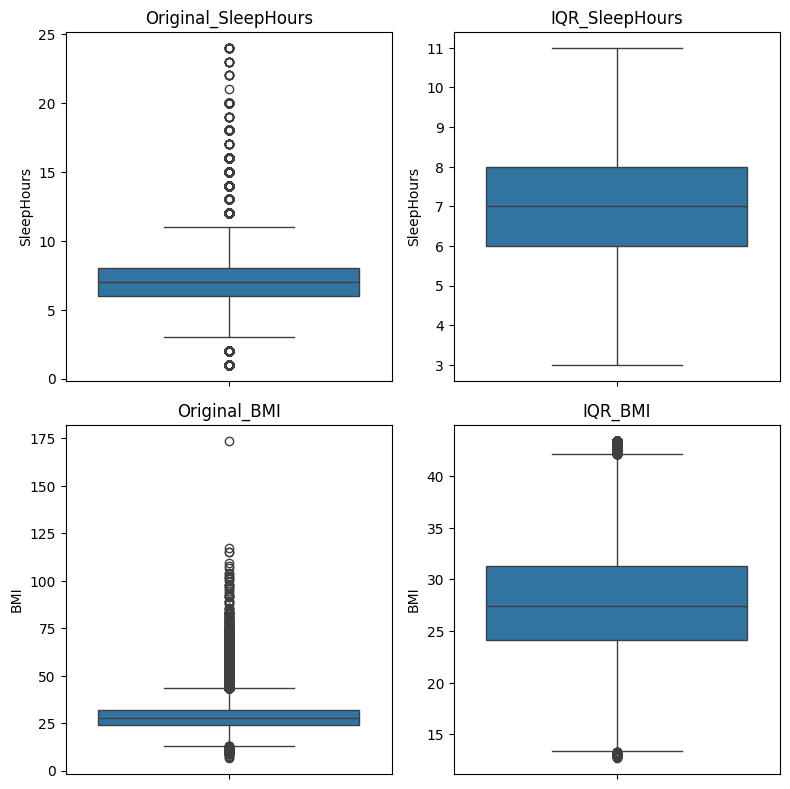

In [140]:
plt.figure(figsize = (8, 8))

plt.subplot(2, 2, 1)
sns.boxplot(data = data['SleepHours'])
plt.title('Original_SleepHours')

plt.subplot(2, 2, 2)
sns.boxplot(data = data_iqr['SleepHours'])
plt.title('IQR_SleepHours')

plt.subplot(2, 2, 3)
sns.boxplot(data = data['BMI'])
plt.title('Original_BMI')

plt.subplot(2, 2, 4)
sns.boxplot(data = data_iqr['BMI'])
plt.title('IQR_BMI')

plt.tight_layout()
plt.show()

In [9]:
X_iqr = data_iqr.drop('HadHeartAttack', axis = 1)
y_iqr = data_iqr['HadHeartAttack']

In [10]:
X_train_iqr, X_test_iqr, y_train_iqr, y_test_iqr = train_test_split(X_iqr, y_iqr, test_size = 0.2, random_state = 1234)

In [11]:
rbs = RobustScaler()
X_train_iqr_rbs = rbs.fit_transform(X_train_iqr)
X_test_iqr_rbs = rbs.transform(X_test_iqr)

### SGD Classifier

In [23]:
sgd_iqr_rbs = SGDClassifier(random_state = 1234)
sgd_iqr_rbs.fit(X_train_iqr_rbs, y_train_iqr)

SGDClassifier(random_state=1234)

In [24]:
sgd_pred_iqr_rbs = sgd_iqr_rbs.predict(X_test_iqr_rbs)
sgd_acc_iqr_rbs = accuracy_score(y_test_iqr, sgd_pred_iqr_rbs)
print(f'SGD Classifier (remove outlier + Robust scaling) Accuracy: {sgd_acc_iqr_rbs*100:.2f}%')

SGD Classifier (remove outlier + Robust scaling) Accuracy: 94.25%


In [25]:
print(classification_report(y_test_iqr, sgd_pred_iqr_rbs))

              precision    recall  f1-score   support

           0       0.94      1.00      0.97     49351
           1       0.00      0.00      0.00      3012

    accuracy                           0.94     52363
   macro avg       0.47      0.50      0.49     52363
weighted avg       0.89      0.94      0.91     52363



c:\Users\god12\Anaconda3\envs\wassup\Lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\god12\Anaconda3\envs\wassup\Lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\god12\Anaconda3\envs\wassup\Lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [26]:
sgd_f1_iqr_rbs = f1_score(y_test_iqr, sgd_pred_iqr_rbs)
print(f'SGD Classifier (remove outlier + Robust scaling) F1 score: {sgd_f1_iqr_rbs:.4f}')

SGD Classifier (remove outlier + Robust scaling) F1 score: 0.0000


### AdaBoost

In [27]:
ada_iqr_rbs = AdaBoostClassifier(random_state = 1234)
ada_iqr_rbs.fit(X_train_iqr_rbs, y_train_iqr)

AdaBoostClassifier(random_state=1234)

In [28]:
ada_pred_iqr_rbs = ada_iqr_rbs.predict(X_test_iqr_rbs)
ada_acc_iqr_rbs = accuracy_score(y_test_iqr, sgd_pred_iqr_rbs)
print(f'AdaBoost (IQR + Robust scaling) Accuracy: {ada_acc_iqr_rbs*100:.2f}%')

AdaBoost (IQR + Robust scaling) Accuracy: 94.25%


In [29]:
print(classification_report(y_test_iqr, ada_pred_iqr_rbs))

              precision    recall  f1-score   support

           0       0.96      0.99      0.97     49351
           1       0.55      0.26      0.35      3012

    accuracy                           0.95     52363
   macro avg       0.75      0.62      0.66     52363
weighted avg       0.93      0.95      0.94     52363



In [30]:
ada_f1_iqr_rbs = f1_score(y_test_iqr, ada_pred_iqr_rbs)
print(f'AdaBoost (IQR + Robust scaling) F1 score: {ada_f1_iqr_rbs:.4f}')

AdaBoost (IQR + Robust scaling) F1 score: 0.3524


## 데이터 불균형을 SMOTE로 처리

In [13]:
print(len(X_train))
print(len(X_test))

219227
54807


In [14]:
219227+54807

274034

In [15]:
smo = SMOTE(random_state = 1234)
X_train_smo, y_train_smo = smo.fit_resample(X_train, y_train)
print('Original train data:', len(X_train))
print('Resampled train data:', len(X_train_smo))

Original train data: 219227
Resampled train data: 413976


In [23]:
print(y_train.value_counts()[1])
smo_tmp = pd.concat([X_train_smo, y_train_smo], axis = 1)
print(smo_tmp[smo_tmp['HadHeartAttack'] == 1].duplicated().sum())

12239
106


### SGD Classifier

In [24]:
sgd_smo = SGDClassifier(random_state = 1234)
sgd_smo.fit(X_train_smo, y_train_smo)

SGDClassifier(random_state=1234)

In [25]:
sgd_pred_smo = sgd_smo.predict(X_test)
sgd_acc_smo = accuracy_score(y_test, sgd_pred_smo)
print(f'SGD Classifier (SMOTE) Accuracy: {sgd_acc_smo*100:.2f}%')

SGD Classifier (SMOTE) Accuracy: 78.15%


In [26]:
print(classification_report(y_test, sgd_pred_smo))

              precision    recall  f1-score   support

           0       0.97      0.79      0.87     51607
           1       0.16      0.66      0.26      3200

    accuracy                           0.78     54807
   macro avg       0.57      0.72      0.57     54807
weighted avg       0.93      0.78      0.84     54807



In [27]:
sgd_f1_smo = f1_score(y_test, sgd_pred_smo)
print(f'SGD Classifier (SMOTE) F1 score: {sgd_f1_smo:.4f}')

SGD Classifier (SMOTE) F1 score: 0.2604


### AdaBoost

In [28]:
ada_smo = AdaBoostClassifier(random_state = 1234)
ada_smo.fit(X_train_smo, y_train_smo)

AdaBoostClassifier(random_state=1234)

In [29]:
ada_pred_smo = ada_smo.predict(X_test)
ada_acc_smo = accuracy_score(y_test, ada_pred_smo)
print(f'AdaBoost (SMOTE) Accuracy: {ada_acc_smo*100:.2f}%')

AdaBoost (SMOTE) Accuracy: 91.53%


In [30]:
print(classification_report(y_test, ada_pred_smo))

              precision    recall  f1-score   support

           0       0.96      0.95      0.95     51607
           1       0.31      0.38      0.34      3200

    accuracy                           0.92     54807
   macro avg       0.64      0.66      0.65     54807
weighted avg       0.92      0.92      0.92     54807



In [31]:
ada_f1_smo = f1_score(y_test, ada_pred_smo)
print(f'AdaBoost (SMOTE) F1 score: {ada_f1_smo:.4f}')

AdaBoost (SMOTE) F1 score: 0.3437


## IQR + SMOTE + Robust Scaling

In [ ]:
X_train_iqr

In [32]:
smo = SMOTE(random_state = 1234)
X_train_iqr_smo, y_train_iqr_smo = smo.fit_resample(X_train_iqr, y_train_iqr)
print('Original train data:', len(X_train))
print('IQRed train data:', len(X_train_iqr))
print('Resampled data:', len(X_train_iqr_smo))

Original train data: 219227
IQRed train data: 209449
Resampled data: 396072


In [33]:
rbs = RobustScaler()
X_train_iqr_smo_rbs = rbs.fit_transform(X_train_iqr_smo)
X_test_iqr_smo_rbs = rbs.transform(X_test_iqr)

### SGD Classifier

In [34]:
sgd_iqr_smo_rbs = SGDClassifier(random_state = 1234)
sgd_iqr_smo_rbs.fit(X_train_iqr_smo_rbs, y_train_iqr_smo)

SGDClassifier(random_state=1234)

In [35]:
sgd_pred_iqr_smo_rbs = sgd_iqr_smo_rbs.predict(X_test_iqr_smo_rbs)
sgd_acc_iqr_smo_rbs = accuracy_score(y_test_iqr, sgd_pred_iqr_smo_rbs)
print(f'SGD Classifier (IQR + SMOTE + Robust scaling) Accuracy: {sgd_acc_iqr_smo_rbs*100:.2f}')

SGD Classifier (IQR + SMOTE + Robust scaling) Accuracy: 91.90


In [36]:
print(classification_report(y_test_iqr, sgd_pred_iqr_smo_rbs))

              precision    recall  f1-score   support

           0       0.96      0.95      0.96     49351
           1       0.33      0.39      0.36      3012

    accuracy                           0.92     52363
   macro avg       0.65      0.67      0.66     52363
weighted avg       0.93      0.92      0.92     52363



In [37]:
sgd_f1_iqr_smo_rbs = f1_score(y_test_iqr, sgd_pred_iqr_smo_rbs)
print(f'SGD Classifier (IQR + SMOTE + Robust scaling) F1 score: {sgd_f1_iqr_smo_rbs:.4f}')

SGD Classifier (IQR + SMOTE + Robust scaling) F1 score: 0.3562


In [38]:
print(confusion_matrix(y_test_iqr, sgd_pred_iqr_smo_rbs))

[[46945  2406]
 [ 1838  1174]]


### AdaBoost

In [39]:
ada_iqr_smo_rbs = AdaBoostClassifier(random_state = 1234)
ada_iqr_smo_rbs.fit(X_train_iqr_smo_rbs, y_train_iqr_smo)

AdaBoostClassifier(random_state=1234)

In [40]:
ada_pred_iqr_smo_rbs = ada_iqr_smo_rbs.predict(X_test_iqr_smo_rbs)
ada_acc_iqr_smo_rbs = accuracy_score(y_test_iqr, ada_pred_iqr_smo_rbs)
print(f'AdaBoost (IQR + SMOTE + Robust scaling) Accuracy: {ada_acc_iqr_smo_rbs*100:.2f}%')

AdaBoost (IQR + SMOTE + Robust scaling) Accuracy: 91.94%


In [41]:
print(classification_report(y_test_iqr, ada_pred_iqr_smo_rbs))

              precision    recall  f1-score   support

           0       0.96      0.95      0.96     49351
           1       0.32      0.37      0.34      3012

    accuracy                           0.92     52363
   macro avg       0.64      0.66      0.65     52363
weighted avg       0.92      0.92      0.92     52363



In [42]:
ada_f1_iqr_smo_rbs = f1_score(y_test_iqr, ada_pred_iqr_smo_rbs)
print(f'AdaBoost (IQR + SMOTE + Robust scaling) F1 score: {ada_f1_iqr_smo_rbs:.4f}')

AdaBoost (IQR + SMOTE + Robust scaling) F1 score: 0.3425


In [43]:
print(confusion_matrix(y_test_iqr, ada_pred_iqr_smo_rbs))

[[47040  2311]
 [ 1912  1100]]


AdaBoost base model 변경

In [44]:
base_model = DecisionTreeClassifier(max_depth = 5, min_samples_leaf = 10)
ada = AdaBoostClassifier(estimator = base_model, random_state = 1234)
ada.fit(X_train_iqr_smo_rbs, y_train_iqr_smo)

AdaBoostClassifier(estimator=DecisionTreeClassifier(max_depth=5,
                                                    min_samples_leaf=10),
                   random_state=1234)

In [45]:
ada_pred = ada.predict(X_test_iqr_smo_rbs)
ada_acc = accuracy_score(y_test_iqr, ada_pred)
print(f'AadBoost (IQR + SMOTE + Robust) Accuracy: {ada_acc*100:.2f}%')

AadBoost (IQR + SMOTE + Robust) Accuracy: 94.11%


In [46]:
print(classification_report(y_test_iqr, ada_pred))

              precision    recall  f1-score   support

           0       0.96      0.98      0.97     49351
           1       0.48      0.25      0.33      3012

    accuracy                           0.94     52363
   macro avg       0.72      0.62      0.65     52363
weighted avg       0.93      0.94      0.93     52363



In [47]:
ada_f1 = f1_score(y_test_iqr, ada_pred)
print(f'AdaBoost (IQR + SMOTE + Robust) F1 score: {ada_f1:.4f}')

AdaBoost (IQR + SMOTE + Robust) F1 score: 0.3319


In [48]:
print(confusion_matrix(y_test_iqr, ada_pred))

[[48513   838]
 [ 2246   766]]


# Feature Engineering

In [ ]:
smo = SMOTE(random_state = 1234)
X_iqr_smo, y_iqr_smo = smo.fit_resample(X_iqr, y_iqr)   #X_re, y_re
print('Original data:', len(X))
print('IQRed data:', len(X_iqr))
print('Resampled data:', len(X_iqr_smo))

In [65]:
X_corr = X_iqr_smo[['HadAngina', 'HadStroke', 'HadCOPD', 'HadKidneyDisease', 'HadArthritis', 'HadDiabetes', 'DifficultyWalking', 'ChestScan', 'AgeCategory', 'PneumoVaxEver']]
X_general = X_iqr_smo[['Sex', 'GeneralHealth', 'PhysicalHealthDays', 'MentalHealthDays',
                'LastCheckupTime', 'PhysicalActivities', 'SleepHours', 'RemovedTeeth',
                'SmokerStatus', 'ECigaretteUsage', 'ChestScan', 'AgeCategory',
                'HeightInMeters', 'WeightInKilograms', 'BMI', 'AlcoholDrinkers', 'HighRiskLastYear',
                'RaceEthnicityCategory_Black only, Non-Hispanic', 'RaceEthnicityCategory_Hispanic', 'RaceEthnicityCategory_Multiracial, Non-Hispanic', 'RaceEthnicityCategory_Other race only, Non-Hispanic', 'RaceEthnicityCategory_White only, Non-Hispanic',
                'TetanusLast10Tdap_No, did not receive any tetanus shot in the past 10 years', 'TetanusLast10Tdap_Yes, received Tdap', 'TetanusLast10Tdap_Yes, received tetanus shot but not sure what type', 'TetanusLast10Tdap_Yes, received tetanus shot, but not Tdap']]
X_disease = X_iqr_smo[['HadAngina', 'HadStroke', 'HadAsthma', 'HadSkinCancer', 'HadCOPD', 'HadDepressiveDisorder', 'HadKidneyDisease', 'HadArthritis', 'HadDiabetes',
                'DeafOrHardOfHearing', 'BlindOrVisionDifficulty', 'DifficultyConcentrating', 'DifficultyWalking', 'DifficultyDressingBathing', 'DifficultyErrands',
                'HIVTesting', 'FluVaxLast12', 'PneumoVaxEver', 'CovidPos']]
X_chest = X_iqr_smo[['State', 'Sex', 'AgeCategory', 'GeneralHealth', 'HadStroke', 'HadAsthma', 'HadCOPD', 'SmokerStatus']]
X_heart = X_iqr_smo[['BMI', 'PhysicalActivities', 'SmokerStatus', 'ECigaretteUsage', 'HadDiabetes', 'AlcoholDrinkers', 'HadAngina']]

## X with Correlation

In [66]:
X_trn_corr, X_tst_corr, y_trn_corr, y_tst_corr = train_test_split(X_corr, y_iqr_smo, test_size = 0.2, random_state = 1234)

In [67]:
rbs = RobustScaler()
X_trn_corr_scaled = rbs.fit_transform(X_trn_corr)
X_tst_corr_scaled = rbs.transform(X_tst_corr)

### SGD Classifier

In [68]:
sgd = SGDClassifier(random_state = 1234)
sgd.fit(X_trn_corr_scaled, y_trn_corr)

SGDClassifier(random_state=1234)

In [74]:
sgd_corr_pred = sgd.predict(X_tst_corr_scaled)
sgd_corr_acc = accuracy_score(y_tst_corr, sgd_corr_pred)
sgd_corr_f1 = f1_score(y_tst_corr, sgd_corr_pred)
sgd_corr_cm = confusion_matrix(y_tst_corr, sgd_corr_pred)

In [75]:
print(f'SGD Classifier Accuracy (Correlation X): {sgd_corr_acc*100:.2f}%')
print(f'SGD Classifier F1 Score (Correlation X): {sgd_corr_f1:.4f}')

SGD Classifier Accuracy (Correlation X): 72.23%
SGD Classifier F1 Score (Correlation X): 0.7236


In [76]:
print(sgd_corr_cm)

[[35503 13805]
 [13672 35975]]


### AdaBoost

In [77]:
ada = AdaBoostClassifier(estimator = base_model, random_state = 1234)
ada.fit(X_trn_corr_scaled, y_trn_corr)

AdaBoostClassifier(estimator=DecisionTreeClassifier(max_depth=5,
                                                    min_samples_leaf=10),
                   random_state=1234)

In [78]:
ada_corr_pred = ada.predict(X_tst_corr_scaled)
ada_corr_acc = accuracy_score(y_tst_corr, ada_corr_pred)
ada_corr_f1 = f1_score(y_tst_corr, ada_corr_pred)
ada_corr_cm = confusion_matrix(y_tst_corr, ada_corr_pred)

In [79]:
print(f'AdaBoost Accuracy (Correlation X): {ada_corr_acc*100:.2f}%')
print(f'AdaBoost F1 Score (Correlation X): {ada_corr_f1:.4f}')

AdaBoost Accuracy (Correlation X): 78.22%
AdaBoost F1 Score (Correlation X): 0.7762


In [80]:
print(ada_corr_cm)

[[40024  9284]
 [12270 37377]]


## X with General Health

In [81]:
X_trn_g, X_tst_g, y_trn_g, y_tst_g = train_test_split(X_general, y_iqr_smo, test_size = 0.2, random_state = 1234)

In [82]:
rbs = RobustScaler()
X_trn_g_scaled = rbs.fit_transform(X_trn_g)
X_tst_g_scaled = rbs.transform(X_tst_g)

### SGD Classifier

In [83]:
sgd = SGDClassifier(random_state = 1234)
sgd.fit(X_trn_g_scaled, y_trn_g)

SGDClassifier(random_state=1234)

In [84]:
sgd_g_pred = sgd.predict(X_tst_g_scaled)
sgd_g_acc = accuracy_score(y_tst_g, sgd_g_pred)
sgd_g_f1 = f1_score(y_tst_g, sgd_g_pred)
sgd_g_cm = confusion_matrix(y_tst_g, sgd_g_pred)

In [85]:
print(f'SGD Classifier Accuracy (General X): {sgd_g_acc*100:.2f}%')
print(f'SGD Classifier F1 Score (General X): {sgd_g_f1:.4f}')

SGD Classifier Accuracy (General X): 89.62%
SGD Classifier F1 Score (General X): 0.8935


In [86]:
print(sgd_g_cm)

[[45599  3709]
 [ 6559 43088]]


### AdaBoost

In [87]:
ada = AdaBoostClassifier(estimator = base_model, random_state = 1234)
ada.fit(X_trn_g_scaled, y_trn_g)

AdaBoostClassifier(estimator=DecisionTreeClassifier(max_depth=5,
                                                    min_samples_leaf=10),
                   random_state=1234)

In [88]:
ada_g_pred = ada.predict(X_tst_g_scaled)
ada_g_acc = accuracy_score(y_tst_g, ada_g_pred)
ada_g_f1 = f1_score(y_tst_g, ada_g_pred)
ada_g_cm = confusion_matrix(y_tst_g, ada_g_pred)

In [89]:
print(f'AdaBoost Accuracy (Correlation X): {ada_g_acc*100:.2f}%')
print(f'AdaBoost F1 Score (Correlation X): {ada_g_f1:.4f}')

AdaBoost Accuracy (Correlation X): 96.80%
AdaBoost F1 Score (Correlation X): 0.9672


In [90]:
print(ada_g_cm)

[[49017   291]
 [ 2878 46769]]


## X with Disease

In [91]:
X_trn_d, X_tst_d, y_trn_d, y_tst_d = train_test_split(X_disease, y_iqr_smo, test_size = 0.2, random_state = 1234)

In [92]:
rbs = RobustScaler()
X_trn_d_scaled = rbs.fit_transform(X_trn_d)
X_tst_d_scaled = rbs.transform(X_tst_d)

### SGD Classifier

In [93]:
sgd = SGDClassifier(random_state = 1234)
sgd.fit(X_trn_d_scaled, y_trn_d)

SGDClassifier(random_state=1234)

In [94]:
sgd_d_pred = sgd.predict(X_tst_d_scaled)
sgd_d_acc = accuracy_score(y_tst_d, sgd_d_pred)
sgd_d_f1 = f1_score(y_tst_d, sgd_d_pred)
sgd_d_cm = confusion_matrix(y_tst_d, sgd_d_pred)

In [95]:
print(f'SGD Classifier Accuracy (Disease X): {sgd_d_acc*100:.2f}%')
print(f'SGD Classifier F1 Score (Disease X): {sgd_d_f1:.4f}')

SGD Classifier Accuracy (Disease X): 71.13%
SGD Classifier F1 Score (Disease X): 0.7121


In [96]:
print(sgd_d_cm)

[[35054 14254]
 [14314 35333]]


### AdaBoost

In [97]:
ada = AdaBoostClassifier(estimator = base_model, random_state = 1234)
ada.fit(X_trn_d_scaled, y_trn_d)

AdaBoostClassifier(estimator=DecisionTreeClassifier(max_depth=5,
                                                    min_samples_leaf=10),
                   random_state=1234)

In [98]:
ada_d_pred = ada.predict(X_tst_d_scaled)
ada_d_acc = accuracy_score(y_tst_d, ada_d_pred)
ada_d_f1 = f1_score(y_tst_d, ada_d_pred)
ada_d_cm = confusion_matrix(y_tst_d, ada_d_pred)

In [99]:
print(f'AdaBoost Accuracy (Disease X): {ada_d_acc*100:.2f}%')
print(f'AdaBoost F1 Score (Disease X): {ada_d_f1:.4f}')

AdaBoost Accuracy (Disease X): 75.30%
AdaBoost F1 Score (Disease X): 0.7616


In [100]:
print(ada_d_cm)

[[35480 13828]
 [10610 39037]]


## X with Chest

In [101]:
X_trn_c, X_tst_c, y_trn_c, y_tst_c = train_test_split(X_chest, y_iqr_smo, test_size = 0.2, random_state = 1234)

In [102]:
rbs = RobustScaler()
X_trn_c_scaled = rbs.fit_transform(X_trn_c)
X_tst_c_scaled = rbs.fit_transform(X_tst_c)

### SGD Classifier

In [103]:
sgd = SGDClassifier(random_state = 1234)
sgd.fit(X_trn_c_scaled, y_trn_c)

SGDClassifier(random_state=1234)

In [104]:
sgd_c_pred = sgd.predict(X_tst_c_scaled)
sgd_c_acc = accuracy_score(y_tst_c, sgd_c_pred)
sgd_c_f1 = f1_score(y_tst_c, sgd_c_pred)
sgd_c_cm = confusion_matrix(y_tst_c, sgd_c_pred)

In [105]:
print(f'SGD Classifier Accuracy (Chest X): {sgd_c_acc*100:.2f}%')
print(f'SGD Classifier Accuracy (Chest X): {sgd_c_f1:.4f}')

SGD Classifier Accuracy (Chest X): 78.97%
SGD Classifier Accuracy (Chest X): 0.7956


In [106]:
print(sgd_c_cm)

[[37661 11647]
 [ 9160 40487]]


### AdaBoost

In [107]:
ada = AdaBoostClassifier(estimator = base_model, random_state = 1234)
ada.fit(X_trn_c_scaled, y_trn_c)

AdaBoostClassifier(estimator=DecisionTreeClassifier(max_depth=5,
                                                    min_samples_leaf=10),
                   random_state=1234)

In [108]:
ada_c_pred = ada.predict(X_tst_c_scaled)
ada_c_acc = accuracy_score(y_tst_c, ada_c_pred)
ada_c_f1 = f1_score(y_tst_c, ada_c_pred)
ada_c_cm = confusion_matrix(y_tst_c, ada_c_pred)

In [109]:
print(f'AdaBoost Accuracy (Chest X): {ada_c_acc*100:.2f}%')
print(f'AdaBoost F1 Score (Chest X): {ada_c_f1:.4f}')

AdaBoost Accuracy (Chest X): 82.30%
AdaBoost F1 Score (Chest X): 0.8271


In [110]:
print(ada_c_cm)

[[39560  9748]
 [ 7767 41880]]


## X with Heart Disease

In [111]:
X_trn_h, X_tst_h, y_trn_h, y_tst_h = train_test_split(X_heart, y_iqr_smo, test_size = 0.2, random_state = 1234)

In [112]:
rbs = RobustScaler()
X_trn_h_scaled = rbs.fit_transform(X_trn_h)
X_tst_h_scaled = rbs.transform(X_tst_h)

### SGD Classifier

In [113]:
sgd = SGDClassifier(random_state = 1234)
sgd.fit(X_trn_h_scaled, y_trn_h)

SGDClassifier(random_state=1234)

In [114]:
sgd_h_pred = sgd.predict(X_tst_h_scaled)
sgd_h_acc = accuracy_score(y_tst_h, sgd_h_pred)
sgd_h_f1 = f1_score(y_tst_h, sgd_h_pred)
sgd_h_cm = confusion_matrix(y_tst_h, sgd_h_pred)

In [115]:
print(f'SGD Classifier Accuracy (Heart X): {sgd_h_acc*100:.2f}%')
print(f'SGD Classifier F1 Score (Heart X): {sgd_h_f1:.4f}')

SGD Classifier Accuracy (Heart X): 73.13%
SGD Classifier F1 Score (Heart X): 0.7245


In [116]:
print(sgd_h_cm)

[[37408 11900]
 [14689 34958]]


### AdaBoost

In [117]:
ada = AdaBoostClassifier(estimator = base_model, random_state = 1234)
ada.fit(X_trn_h_scaled, y_trn_h)

AdaBoostClassifier(estimator=DecisionTreeClassifier(max_depth=5,
                                                    min_samples_leaf=10),
                   random_state=1234)

In [118]:
ada_h_pred = ada.predict(X_tst_h_scaled)
ada_h_acc = accuracy_score(y_tst_h, ada_h_pred)
ada_h_f1 = f1_score(y_tst_h, ada_h_pred)
ada_h_cm = confusion_matrix(y_tst_h, ada_h_pred)

In [119]:
print(f'AdaBoost Accuracy (Heart X): {ada_h_acc*100:.2f}%')
print(f'AdaBoost F1 Score (Heart X): {ada_h_f1:.4f}')

AdaBoost Accuracy (Heart X): 88.37%
AdaBoost F1 Score (Heart X): 0.8824


In [120]:
print(ada_h_cm)

[[44235  5073]
 [ 6440 43207]]


## y: HadHeartAttack+HadAngina

In [121]:
data_iqr['HeartDisease'] = 0
data_iqr.loc[data['HadHeartAttack'] == 1, 'HeartDisease'] = 1
data_iqr.loc[data['HadAngina'] == 1, 'HeartDisease'] = 1

In [122]:
print(len(data_iqr[data_iqr['HeartDisease'] == 1]))
print(len(data_iqr[data_iqr['HeartDisease'] == 0]))

23199
238613


In [123]:
X1 = data_iqr.drop(['HadHeartAttack', 'HadAngina', 'HeartDisease'], axis = 1)
y1 = data_iqr['HeartDisease']

In [124]:
smo = SMOTE(random_state = 1234)
X_re1, y_re1 = smo.fit_resample(X1, y1)
print('Resampled Data:', len(X_re1))

Resampled Data: 477226


In [125]:
X_train1, X_test1, y_train1, y_test1 = train_test_split(X_re1, y_re1, test_size = 0.2, random_state = 1234)

In [126]:
rbs = RobustScaler()
X_train_scaled = rbs.fit_transform(X_train1)
X_test_scaled = rbs.transform(X_test1)

### SGD Classifier

In [127]:
sgd = SGDClassifier(random_state = 1234)
sgd.fit(X_train_scaled, y_train1)

SGDClassifier(random_state=1234)

In [128]:
sgd_pred = sgd.predict(X_test_scaled)
sgd_acc = accuracy_score(y_test1, sgd_pred)
sgd_f1 = f1_score(y_test1, sgd_pred)
sgd_cm = confusion_matrix(y_test1, sgd_pred)

In [129]:
print(f'SGD Classifier Accuracy: {sgd_acc*100:.2f}%')
print(f'SGD Classifier F1 score: {sgd_f1:.4f}')

SGD Classifier Accuracy: 89.73%
SGD Classifier F1 score: 0.8942


In [130]:
print(classification_report(y_test1, sgd_pred))

              precision    recall  f1-score   support

           0       0.87      0.93      0.90     47506
           1       0.93      0.86      0.89     47940

    accuracy                           0.90     95446
   macro avg       0.90      0.90      0.90     95446
weighted avg       0.90      0.90      0.90     95446



In [131]:
print(sgd_cm)

[[44255  3251]
 [ 6548 41392]]


### AdaBoost

In [132]:
ada = AdaBoostClassifier(estimator = base_model, random_state = 1234)
ada.fit(X_train_scaled, y_train1)

AdaBoostClassifier(estimator=DecisionTreeClassifier(max_depth=5,
                                                    min_samples_leaf=10),
                   random_state=1234)

In [133]:
ada_pred = ada.predict(X_test_scaled)
ada_acc = accuracy_score(y_test1, ada_pred)
ada_f1 = f1_score(y_test1, ada_pred)
ada_cm = confusion_matrix(y_test1, ada_pred)

In [134]:
print(f'AdaBoost Accuracy: {ada_acc*100:.2f}%')
print(f'AdaBoost F1 score: {ada_f1:.4f}')

AdaBoost Accuracy: 94.61%
AdaBoost F1 score: 0.9445


In [135]:
print(classification_report(y_test1, ada_pred))

              precision    recall  f1-score   support

           0       0.92      0.98      0.95     47506
           1       0.98      0.91      0.94     47940

    accuracy                           0.95     95446
   macro avg       0.95      0.95      0.95     95446
weighted avg       0.95      0.95      0.95     95446



In [136]:
print(ada_cm)

[[46489  1017]
 [ 4130 43810]]
